In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import os
databasePath = os.getcwd()
imgDirPath = databasePath + "/leedsbutterfly/images"
segDirPath = databasePath + "/leedsbutterfly/segmentations"

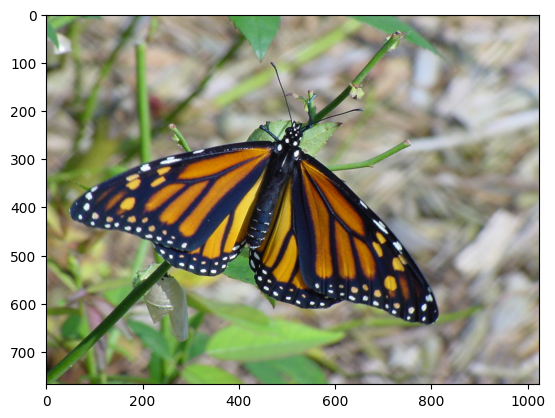

In [3]:
testImg = cv2.imread("{}/0010001.png".format(imgDirPath))
testImg = cv2.cvtColor(testImg, cv2.COLOR_BGR2RGB)
plt.imshow(testImg)
plt.show()

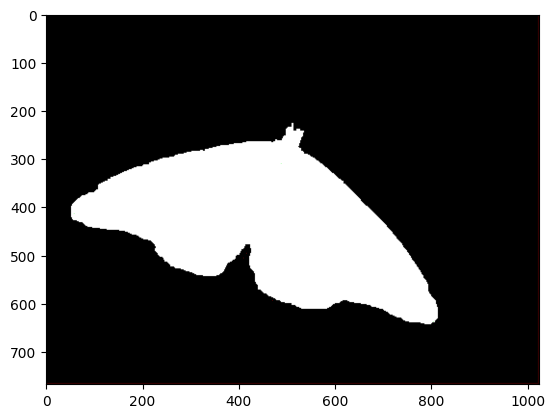

In [4]:
testSegImg = cv2.imread("{}/0010001_seg0.png".format(segDirPath))
testSegImg = cv2.cvtColor(testSegImg, cv2.COLOR_BGR2RGB)
plt.imshow(testSegImg)
plt.show()

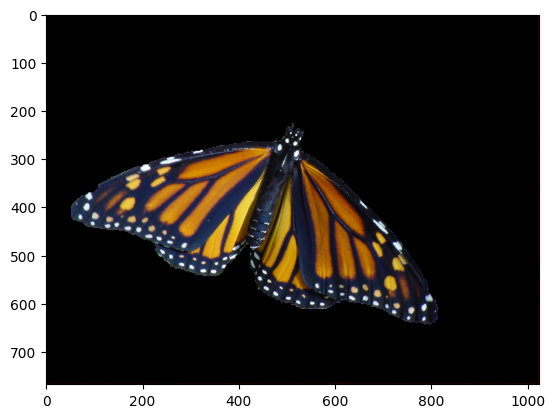

In [5]:
testObjImg = np.multiply(testImg/255, testSegImg/255) # testImg as base img, testSegImg as cutter
plt.imshow(testObjImg)
plt.show()

In [6]:
listImg = os.listdir(imgDirPath)
listSeg = os.listdir(segDirPath)

In [7]:
imgCat = []
segCat = []
for i in range(10):
    listImg_i = [spec for spec in listImg if spec.startswith(str(i+1).zfill(3))]
    listSeg_i = [spec for spec in listSeg if spec.startswith(str(i+1).zfill(3))]
    imgCat.append(listImg_i)
    segCat.append(listSeg_i)

In [8]:
import random
RAN_NUM = 30
selected_img = []
selected_seg = []
for i in range(10):
    listImg_i = imgCat[i]
    listSeg_i = segCat[i]
    tmp_selected_img = random.sample(listImg_i, RAN_NUM)
    selected_img += tmp_selected_img
    list_idx = [listImg_i.index(s) for s in tmp_selected_img]
    selected_seg += [listSeg_i[i] for i in list_idx]
    
listImgForTrain = [imgDirPath + "/" + img for img in selected_img]
listSegForTrain = [segDirPath + "/" + seg for seg in selected_seg]

In [9]:
import time
iter = len(listImgForTrain)
all_objects_pixels=[]
for i in range(iter):
    img = cv2.imread(listImgForTrain[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    seg = cv2.imread(listSegForTrain[i])
    seg = cv2.cvtColor(seg, cv2.COLOR_BGR2RGB)
    imgNorm = img / 255.0
    segNorm = seg / 255.0
    segmented_object = np.multiply(imgNorm, segNorm)
    img_shape = np.shape(segmented_object)
    segmented_object = segmented_object.reshape((img_shape[0]*img_shape[1], 3)) # convert to 2 dimension

    all_objects_pixels.append(segmented_object)
all_objects = np.vstack(all_objects_pixels)

In [10]:
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

n_colors = 16
image_array_sample = shuffle(all_objects, random_state=0, n_samples=4000)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)


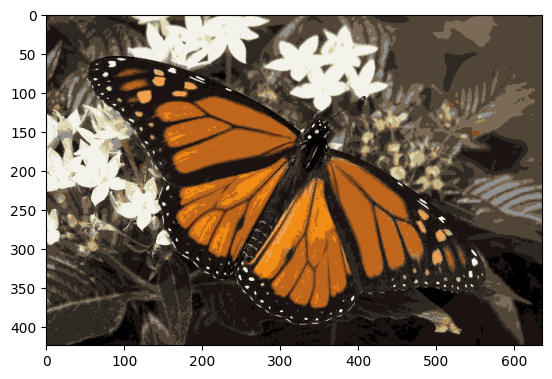

In [11]:

# hien thi hinh anh voi so mau sac it hon
imgBRG = cv2.imread("{}/0010006.png".format(imgDirPath))
imgRGB = cv2.cvtColor(imgBRG, cv2.COLOR_BGR2RGB)
imgRGB = imgRGB/255

imgRGB_array = imgRGB.reshape((-1, 3))

imRGBnew = kmeans.cluster_centers_[kmeans.predict(imgRGB_array)]
imRGBnew = np.reshape(imRGBnew, np.shape(imgRGB))

plt.imshow(imRGBnew)
plt.show()

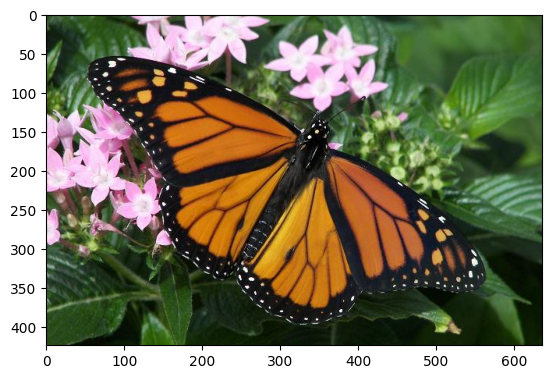

In [12]:
plt.imshow(imgRGB)
plt.show()

In [13]:
color_ids = kmeans.predict(imgRGB_array)
histogram = np.histogram(color_ids, bins=n_colors, range=(0, n_colors))[0]/np.shape(imgRGB_array)[0]
print(histogram)

[0.03255533 0.02138587 0.08248413 0.00523985 0.20011941 0.08209105
 0.2014544  0.01389878 0.09791815 0.01604589 0.16299172 0.02180491
 0.021486   0.03030438 0.00053771 0.00968242]


In [14]:
### Ap dung phuong thuc ma hoa mau sac tren cho toan bo du lieu
# su dung thong tin histogram de lam data cho training
# su dung 3 ky tu dau cua anh de lam label
imgList = []
segList = []
for i in range(10):
    imgList += imgCat[i]
    segList += segCat[i]

labelList = [label[:3] for label in imgList]
testImgList = [imgDirPath + "/" + img for img in imgList]
testSegList = [segDirPath + "/" + seg for seg in segList]

In [15]:
myLen = len(testImgList)
histList = []
for i in range(myLen):
    img = cv2.imread(testImgList[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    seg = cv2.imread(testSegList[i])
    seg = cv2.cvtColor(seg, cv2.COLOR_BGR2RGB)
    img_norm = img / 255.0
    seg_norm = seg / 255.0
    segmented_object = np.multiply(img_norm, seg_norm)
    img_shape = np.shape(segmented_object)
    segmented_object = segmented_object.reshape((img_shape[0]*img_shape[1], 3)) # convert to 2 dimension

    color_ids = kmeans.predict(segmented_object)
    histogram = np.histogram(color_ids, bins=n_colors, range=(0, n_colors))[0]/(img_shape[0]*img_shape[1])
    histList.append(histogram)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(histList, labelList, test_size=0.2, random_state=30)

In [24]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(n_estimators=87, random_state=99)
RFC.fit(X_train, y_train)
score = RFC.score(X_test, y_test)
print(score)

0.8383233532934131


In [18]:
from sklearn.ensemble import HistGradientBoostingClassifier
HGBC = HistGradientBoostingClassifier(max_iter=200).fit(X_train, y_train)
score = HGBC.score(X_test, y_test)
print(score)

0.8143712574850299


In [19]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors=13, p=1, weights='distance',algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None)
KNN.fit(X_train, y_train)
score = KNN.score(X_test, y_test)
print(score)

0.6107784431137725


In [20]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
SVM = make_pipeline(StandardScaler(), SVC(C=4, kernel='rbf', degree=1, gamma='auto'))
SVM.fit(X_train, y_train)
score = SVM.score(X_test, y_test)
print(score)

0.7904191616766467
